In [74]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import label, distance_transform_edt
import platform
import torch
import io
from PIL import Image

In [44]:
# check for gpu otherwise use cpu
if platform.system() == "Darwin":  # checking if it's macOS
    if torch.backends.mps.is_available():
        device = torch.device("mps")
elif torch.cuda.is_available():  # if not macOS, check for CUDA availability
    device = torch.device("cuda")
else:  # if neither macOS nor CUDA, default to CPU
    device = torch.device("cpu")
print(f"Using {device} device for training.")

Using mps device for training.


In [86]:
#### USER INPUTS ####

image_path = './example_images/tom_starry_night.jpg'

n_segments = 1000
compactness = 10

n_colors = 30

In [3]:
def label_regions_within_edges(quantized_indices, edges, min_segment_size=100, max_attempts=3, boundary_padding=5):
    # Create a white background image
    labeled_image = np.ones((quantized_indices.shape[0], quantized_indices.shape[1], 3), dtype=np.uint8) * 255
    height, width = quantized_indices.shape

    # Loop through each unique color index in the quantized image
    unique_colors = np.unique(quantized_indices)
    
    for color_index in unique_colors:
        # Create a mask for the current color region
        mask = quantized_indices == color_index
        
        # Label connected components in the mask
        labeled_mask, num_features = label(mask)
        
        for i in range(1, num_features + 1):
            # Find the coordinates of the current region
            region_mask = labeled_mask == i

            # Skip very small regions to avoid clutter
            if np.sum(region_mask) < min_segment_size:
                continue

            # Apply a distance transform to find the point farthest from the edges
            distance_transform = distance_transform_edt(region_mask)
            max_dist_idx = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
            final_x, final_y = max_dist_idx[1], max_dist_idx[0]

            # Determine an appropriate text size based on the region size
            region_area = np.sum(region_mask)
            font_scale = min(0.4, max(0.1, region_area / 1000))  # Dynamic font scale

            # Check if the placement is within image boundaries (including edge segments)
            if (boundary_padding < final_x < width - boundary_padding and
                boundary_padding < final_y < height - boundary_padding):
                # Placement is within the boundaries; place the number
                text = str(color_index + 1)
                text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)[0]
                text_x = final_x - text_size[0] // 2
                text_y = final_y + text_size[1] // 2

                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 85), 1, cv2.LINE_AA)

            else:
                # Handle edge segments; attempt to place the number inside the region
                distance_transform = distance_transform_edt(region_mask)
                max_dist_idx = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
                adjusted_x, adjusted_y = max_dist_idx[1], max_dist_idx[0]

                # Adjust placement to stay within the image boundaries
                adjusted_x = np.clip(adjusted_x, boundary_padding, width - boundary_padding)
                adjusted_y = np.clip(adjusted_y, boundary_padding, height - boundary_padding)

                # Place the number at the new point
                text = str(color_index + 1)
                text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)[0]
                text_x = adjusted_x - text_size[0] // 2
                text_y = adjusted_y + text_size[1] // 2

                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 85), 1, cv2.LINE_AA)

    # Add black edges to the labeled image
    labeled_image[edges == 0] = 0  # Set edge pixels to black

    return labeled_image

In [4]:
def slic_superpixel_segmentation(image, n_segments=500, compactness=10):
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    return segments

In [5]:
def quantize_superpixels(image, segments, n_colors=30):
    lab_image = rgb2lab(image)
    unique_segments = np.unique(segments)
    avg_colors = []

    for segment_value in unique_segments:
        mask = segments == segment_value
        avg_color = np.mean(lab_image[mask], axis=0)
        avg_colors.append(avg_color)

    avg_colors = np.array(avg_colors)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(avg_colors)
    quantized_colors = kmeans.cluster_centers_

    quantized_image = np.zeros_like(lab_image)
    quantized_indices = np.zeros(segments.shape, dtype=np.int32)
    for i, segment_value in enumerate(unique_segments):
        mask = segments == segment_value
        quantized_image[mask] = quantized_colors[kmeans.labels_[i]]
        quantized_indices[mask] = kmeans.labels_[i]

    quantized_image = lab2rgb(quantized_image)
    return (quantized_image * 255).astype(np.uint8), quantized_indices, quantized_colors

In [95]:
def label_regions_within_edges(quantized_indices, edges, min_segment_size=100, boundary_padding=5, extra_padding=5):
    # Create a white background image
    labeled_image = np.ones((quantized_indices.shape[0], quantized_indices.shape[1], 3), dtype=np.uint8) * 255
    height, width = quantized_indices.shape

    # Loop through each unique color index in the quantized image
    unique_colors = np.unique(quantized_indices)
    
    for color_index in unique_colors:
        # Create a mask for the current color region
        mask = quantized_indices == color_index
        
        # Label connected components in the mask
        labeled_mask, num_features = label(mask)
        
        for i in range(1, num_features + 1):
            # Find the coordinates of the current region
            region_mask = labeled_mask == i

            # Skip very small regions to avoid clutter
            if np.sum(region_mask) < min_segment_size:
                continue

            # Apply a distance transform to find the point farthest from the edges
            distance_transform = distance_transform_edt(region_mask)
            max_dist_idx = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
            final_x, final_y = max_dist_idx[1], max_dist_idx[0]

            # Determine an appropriate text size based on the region size
            region_area = np.sum(region_mask)
            font_scale = min(0.4, max(0.1, region_area / 1000))  # Dynamic font scale

            # Adjust final_x and final_y to add extra padding
            final_x = np.clip(final_x, boundary_padding + extra_padding, width - boundary_padding - extra_padding)
            final_y = np.clip(final_y, boundary_padding + extra_padding, height - boundary_padding - extra_padding)

            # Get text size to check bounding box
            text = str(color_index + 1)
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)[0]
            text_x = final_x - text_size[0] // 2
            text_y = final_y + text_size[1] // 2

            # Check if the bounding box of the text fits inside the region
            fits_inside = True
            for dx in range(-2, text_size[0] + 2):  # Check along the width of the text
                for dy in range(-text_size[1], 2):  # Check along the height of the text
                    check_x = text_x + dx
                    check_y = text_y + dy
                    if not (0 <= check_x < width and 0 <= check_y < height and region_mask[check_y, check_x]):
                        fits_inside = False
                        break
                if not fits_inside:
                    break

            if fits_inside:
                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (208, 153, 98), 1, cv2.LINE_AA)
            else:
                # If it doesn't fit, place the number at the centroid, even if it goes over the border
                text_x = final_x - text_size[0] // 2
                text_y = final_y + text_size[1] // 2

                # Draw a small white rectangle behind the number to improve visibility
                cv2.rectangle(labeled_image, (text_x - 2, text_y - text_size[1] - 2), 
                              (text_x + text_size[0] + 2, text_y + 2), (255, 255, 255), -1)

                # Draw the label number in royal blue
                cv2.putText(labeled_image, text, (text_x, text_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (208, 153, 98), 1, cv2.LINE_AA)

    # Add black edges to the labeled image
    labeled_image[edges == 0] = 0  # Set edge pixels to black

    return labeled_image


In [7]:
def create_paint_by_number_edges(quantized_indices):
    # Create an edge image by marking the boundaries between quantized color regions
    edges_image = np.zeros(quantized_indices.shape, dtype=np.uint8)
    
    # Check neighboring pixels to find boundaries
    for y in range(quantized_indices.shape[0] - 1):
        for x in range(quantized_indices.shape[1] - 1):
            if quantized_indices[y, x] != quantized_indices[y, x + 1] or quantized_indices[y, x] != quantized_indices[y + 1, x]:
                edges_image[y, x] = 255  # Set boundary pixel to white

    # Invert the edge image for better visibility (black on white)
    edges_image = cv2.bitwise_not(edges_image)
    
    return edges_image


In [8]:
def add_black_border(image, border_size=10):
    # Add a black border to the image
    bordered_image = cv2.copyMakeBorder(
        image,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Black color
    )
    return bordered_image

In [96]:
def display_color_palette(quantized_colors, colors_per_row=10):
    n_colors = len(quantized_colors)
    
    # Convert colors from LAB to RGB
    rgb_colors = lab2rgb(quantized_colors.reshape(1, n_colors, 3)).reshape(n_colors, 3)
    
    # Determine the number of rows needed
    n_rows = int(np.ceil(n_colors / colors_per_row))
    
    # Create a grid of subplots
    fig, ax = plt.subplots(n_rows, colors_per_row, figsize=(15, n_rows * 0.5))
    
    # If there's only one row, ax is not a 2D array, so we need to handle it
    if n_rows == 1:
        ax = np.array([ax])
    
    # Remove axis and set up a grid layout
    for row in range(n_rows):
        for col in range(colors_per_row):
            index = row * colors_per_row + col
            if index < n_colors:
                # Draw the color box with a horizontal aspect ratio
                ax[row, col].add_patch(plt.Rectangle((0, 0), 2, 1, color=rgb_colors[index]))  # Horizontal rectangle
                
                # Place the number to the right of the color box
                ax[row, col].text(2.2, 0.5, str(index + 1), ha='left', va='center', fontsize=12, color='black')
                
                ax[row, col].set_xlim(0, 3)  # Set x limits to fit color box and text
                ax[row, col].set_ylim(0, 1)
            else:
                # Hide unused subplots
                ax[row, col].axis('off')
    
    # Remove axes for each subplot
    for row in range(n_rows):
        for col in range(colors_per_row):
            ax[row, col].axis('off')
    
    plt.tight_layout()

    # Save the figure to a BytesIO object instead of a file
    palette_image_bytes = io.BytesIO()
    fig.savefig(palette_image_bytes, format='PNG', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close(fig)  # Close the figure to free memory
    palette_image_bytes.seek(0)  # Reset the byte stream's position
    
    # Convert the BytesIO stream to an Image object using PIL
    palette_image = Image.open(palette_image_bytes)
    
    return palette_image

1600 1200


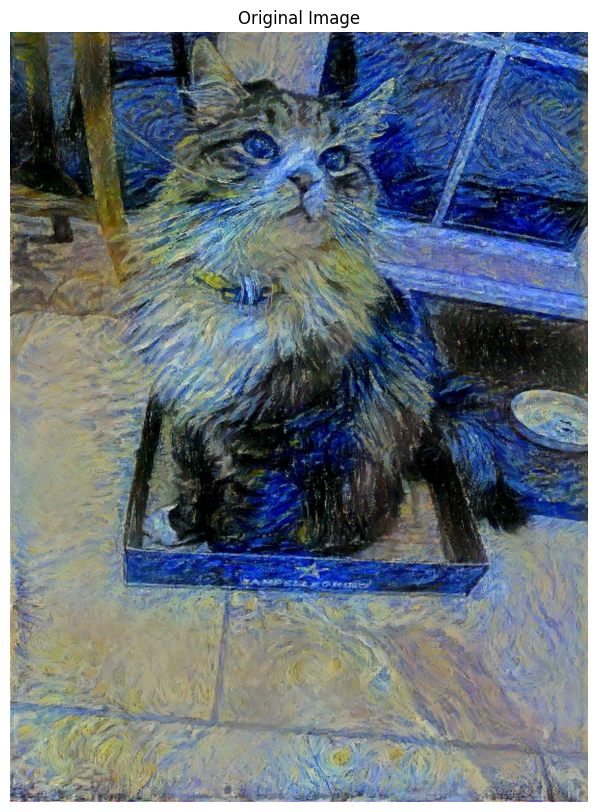

In [71]:
# Load the image

# image_path = './example_images/scenery.jpg'
image = cv2.imread(image_path)

# Resize if necessary
height, width, _ = image.shape

# assert height>1000 or width>1000

max_dimension = 2000
if height > max_dimension or width > max_dimension:
    scaling_factor = max_dimension / max(height, width)
    new_width = int(width * scaling_factor)
    new_height = int(height * scaling_factor)
    image = cv2.resize(image, (new_width, new_height))

# Convert image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Double the size
new_width = width * 2
new_height = height * 2

# Resize the image
image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
height, width, _ = image.shape
print(height, width)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

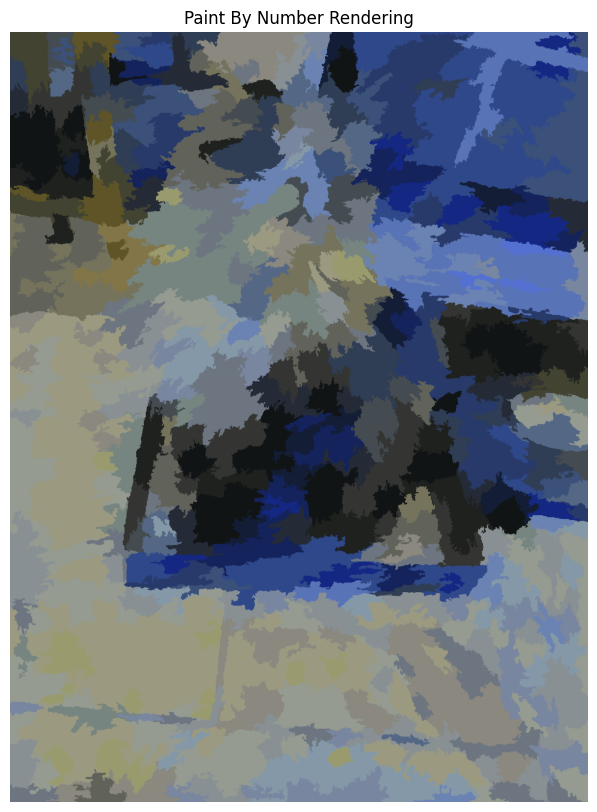

In [87]:
# Quantize the image

# Apply SLIC superpixel segmentation
# n_segments = 2000
# compactness = 10
segments = slic_superpixel_segmentation(image, n_segments=n_segments, compactness=compactness)

# Quantize superpixels to a limited color palette
# n_colors = 20
quantized_image, quantized_indices, quantized_colors = quantize_superpixels(image, segments, n_colors=n_colors)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(quantized_image)
plt.title('Paint By Number Rendering')
plt.axis('off')
plt.show()

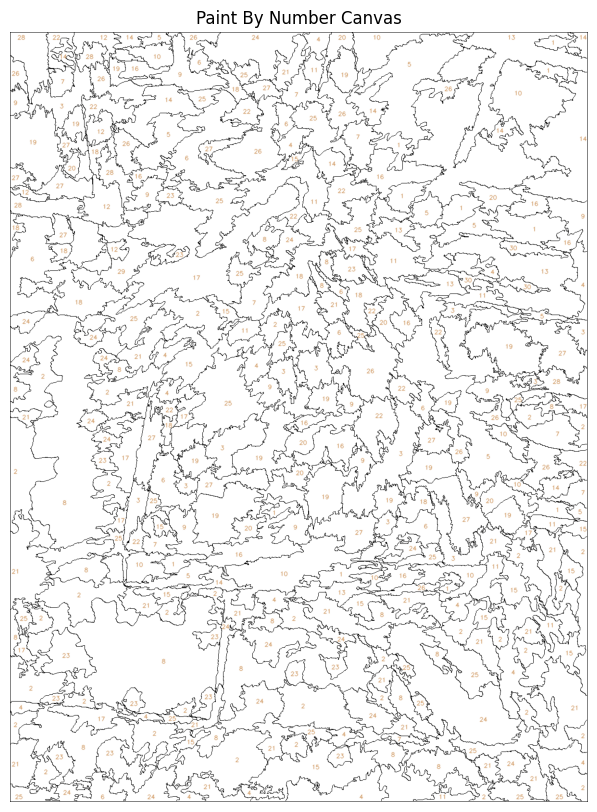

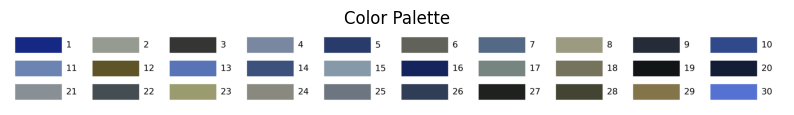

In [97]:
### Create black and white image with numbers and colour palette

# Create edges and labeled image
edges = create_paint_by_number_edges(quantized_indices)
labeled_image_on_white = label_regions_within_edges(quantized_indices, edges)

# Add a black border around 'labeled_image_on_white'
labeled_image_on_white_with_border = add_black_border(labeled_image_on_white, border_size=1)


# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(labeled_image_on_white_with_border)
plt.title('Paint By Number Canvas')
plt.axis('off')
plt.show()

# Display the color palette
# display_color_palette(quantized_colors, save_path='my_color_palette.png')
palette_image = display_color_palette(quantized_colors, colors_per_row=10)


# Display the color palette image
plt.figure(figsize=(10, 10))
plt.imshow(palette_image)  # Using the PIL image returned by display_color_palette
plt.title('Color Palette')
plt.axis('off')
plt.show()

In [63]:
# Save labeled_image_on_white as a PNG file
cv2.imwrite('labeled_b.png', labeled_image_on_white_with_border)


True

In [64]:
# Save labeled_image_on_white as a PDF file using matplotlib
plt.imsave('labeled_image_on_white.pdf', labeled_image_on_white)


In [99]:
from PIL import Image
import fitz  # PyMuPDF
import io
import numpy as np

# Assuming 'labeled_image_on_white_with_border' is a NumPy array representing the image
# Assuming 'quantized_colors' is already available for creating the color palette

# Convert 'labeled_image_on_white_with_border' to an in-memory image using PIL
labeled_image_pil = Image.fromarray(labeled_image_on_white_with_border)

# Determine the image's aspect ratio
is_portrait = labeled_image_pil.height > labeled_image_pil.width

# Generate the color palette directly as an image using the modified function
if is_portrait:
    # More columns, fewer rows for portrait
    palette_image_pil = display_color_palette(quantized_colors, colors_per_row=10)
else:
    # More rows, fewer columns for landscape
    palette_image_pil = display_color_palette(quantized_colors, colors_per_row=5)

# Convert both images to byte streams
labeled_image_bytes = io.BytesIO()
labeled_image_pil.save(labeled_image_bytes, format='PNG')
labeled_image_bytes.seek(0)  # Reset stream position

palette_image_bytes = io.BytesIO()
palette_image_pil.save(palette_image_bytes, format='PNG')
palette_image_bytes.seek(0)  # Reset stream position

# Create a new PDF
pdf = fitz.open()

if is_portrait:
    # Set up a portrait PDF page
    pdf_width, pdf_height = labeled_image_pil.width, labeled_image_pil.height + palette_image_pil.height
    pdf_page = pdf.new_page(width=pdf_width, height=pdf_height)
    
    # Place the original image at the top
    pdf_page.insert_image(fitz.Rect(0, 0, labeled_image_pil.width, labeled_image_pil.height), stream=labeled_image_bytes)
    
    # Place the color palette at the bottom
    pdf_page.insert_image(fitz.Rect(0, labeled_image_pil.height, pdf_width, pdf_height), stream=palette_image_bytes)
else:
    # Set up a landscape PDF page
    pdf_width, pdf_height = labeled_image_pil.width + palette_image_pil.width, max(labeled_image_pil.height, palette_image_pil.height)
    pdf_page = pdf.new_page(width=pdf_width, height=pdf_height)
    
    # Place the original image on the right
    pdf_page.insert_image(fitz.Rect(palette_image_pil.width, 0, pdf_width, labeled_image_pil.height), stream=labeled_image_bytes)
    
    # Place the color palette on the left
    pdf_page.insert_image(fitz.Rect(0, 0, palette_image_pil.width, pdf_height), stream=palette_image_bytes)

# Save the PDF
pdf_output_path = 'output.pdf'
pdf.save(pdf_output_path)
pdf.close()

print(f"PDF saved as {pdf_output_path}")


PDF saved as output.pdf


In [100]:
from PIL import Image
import fitz  # PyMuPDF
import io
import numpy as np

# Assuming 'labeled_image_on_white_with_border' is a NumPy array representing the image
# Assuming 'quantized_colors' is already available for creating the color palette

# Convert 'labeled_image_on_white_with_border' to an in-memory image using PIL
labeled_image_pil = Image.fromarray(labeled_image_on_white_with_border)

# Determine the image's aspect ratio
is_portrait = labeled_image_pil.height > labeled_image_pil.width

# Generate the color palette directly as an image using the modified function
if is_portrait:
    # More columns, fewer rows for portrait
    palette_image_pil = display_color_palette(quantized_colors, colors_per_row=10)
else:
    # More rows, fewer columns for landscape
    palette_image_pil = display_color_palette(quantized_colors, colors_per_row=5)

# Define A4 and A3 sizes in points (1 point = 1/72 inches)
A4_WIDTH, A4_HEIGHT = 595, 842  # in points (A4: 8.27 x 11.69 inches)
A3_WIDTH, A3_HEIGHT = 842, 1191  # in points (A3: 11.69 x 16.54 inches)

# Choose paper size (A4 or A3)
paper_width, paper_height = A4_WIDTH, A4_HEIGHT  # Set to A4 size; change to A3_WIDTH, A3_HEIGHT for A3 size

# Resize and position images to fit within the paper dimensions while preserving aspect ratio
if is_portrait:
    # Fit the color palette at the bottom and the labeled image above it
    palette_height = int(paper_height * 0.2)  # Use 20% of the page height for the palette
    main_image_height = paper_height - palette_height

    # Resize images to fit the page width
    palette_image_pil = palette_image_pil.resize((paper_width, palette_height))
    main_image_aspect_ratio = labeled_image_pil.width / labeled_image_pil.height
    main_image_width = paper_width
    main_image_resized_height = int(main_image_width / main_image_aspect_ratio)
    
    # Ensure the main image does not exceed the available space
    if main_image_resized_height > main_image_height:
        main_image_resized_height = main_image_height
        main_image_width = int(main_image_height * main_image_aspect_ratio)

    labeled_image_pil = labeled_image_pil.resize((main_image_width, main_image_resized_height), Image.ANTIALIAS)
else:
    # Fit the color palette on the left and the labeled image on the right
    palette_width = int(paper_width * 0.2)  # Use 20% of the page width for the palette
    main_image_width = paper_width - palette_width

    # Resize images to fit the page height
    palette_image_pil = palette_image_pil.resize((palette_width, paper_height), Image.ANTIALIAS)
    main_image_aspect_ratio = labeled_image_pil.width / labeled_image_pil.height
    main_image_resized_width = int(main_image_height * main_image_aspect_ratio)
    
    # Ensure the main image does not exceed the available space
    if main_image_resized_width > main_image_width:
        main_image_resized_width = main_image_width
        main_image_height = int(main_image_width / main_image_aspect_ratio)

    labeled_image_pil = labeled_image_pil.resize((main_image_resized_width, main_image_height), Image.ANTIALIAS)

# Convert both images to byte streams
labeled_image_bytes = io.BytesIO()
labeled_image_pil.save(labeled_image_bytes, format='PNG')
labeled_image_bytes.seek(0)  # Reset stream position

palette_image_bytes = io.BytesIO()
palette_image_pil.save(palette_image_bytes, format='PNG')
palette_image_bytes.seek(0)  # Reset stream position

# Create a new PDF with the specified paper size
pdf = fitz.open()
pdf_page = pdf.new_page(width=paper_width, height=paper_height)

if is_portrait:
    # Place the original image at the top, centered horizontally
    main_image_x = (paper_width - labeled_image_pil.width) / 2
    pdf_page.insert_image(fitz.Rect(main_image_x, 0, main_image_x + labeled_image_pil.width, labeled_image_pil.height), stream=labeled_image_bytes)
    
    # Place the color palette at the bottom, centered horizontally
    palette_x = (paper_width - palette_image_pil.width) / 2
    pdf_page.insert_image(fitz.Rect(palette_x, labeled_image_pil.height, palette_x + palette_image_pil.width, labeled_image_pil.height + palette_image_pil.height), stream=palette_image_bytes)
else:
    # Place the color palette on the left, centered vertically
    palette_y = (paper_height - palette_image_pil.height) / 2
    pdf_page.insert_image(fitz.Rect(0, palette_y, palette_image_pil.width, palette_y + palette_image_pil.height), stream=palette_image_bytes)
    
    # Place the original image on the right, centered vertically
    main_image_y = (paper_height - labeled_image_pil.height) / 2
    pdf_page.insert_image(fitz.Rect(palette_image_pil.width, main_image_y, palette_image_pil.width + labeled_image_pil.width, main_image_y + labeled_image_pil.height), stream=labeled_image_bytes)

# Save the PDF
pdf_output_path = 'output.pdf'
pdf.save(pdf_output_path)
pdf.close()

print(f"PDF saved as {pdf_output_path}")


AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'